In [91]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import torch
from transformers import BertModel, BertTokenizer

import matplotlib.pyplot as plt
import seaborn as sn

## Example sentences

In [92]:
# SWITCH
#-------
#  - (verb): to turn, shift, or change.
#  - (noun): networking hardware that connects devices on a computer network by using packet switching to receive and forward data to the destination device.
word_of_interest = 'switch'
sentences = ["For example, you can switch to morning or lunchtime workouts.",
             "We must resolutely switch from our present.",
             "Your vehicle's sound system will switch onto mute.",
             "A switch is a device in a computer network that connects other devices together.",
             "Each networked device connected to a switch can be identified by its network address.",
             "A switch normally supports different data rates simultaneously."]

labels = ["For example, you can " + r"$\bf{switch}$" + " to morning or lunchtime workouts.",
          "We must resolutely " + r"$\bf{switch}$" + " from our present.",
          "Your vehicle's sound system will " + r"$\bf{switch}$" + " onto mute.",
          "A " + r"$\bf{switch}$" + " is a device in a computer network that connects other devices together.",
          "Each networked device connected to a " + r"$\bf{switch}$" + " can be identified by its network address",
          "A " + r"$\bf{switch}$" + " normally supports different data rates simultaneously."]

In [87]:
# BRIDGE
#-------
#  - (noun): structure spanning and providing passage over a river, chasm, road, or the like.
#  - (noun): computer networking device that creates a single aggregate network from multiple communication networks or network segments.
word_of_interest = 'bridge'
sentences = ["The water under the bridge started to overflow.",
             "From what he could see from the roadway bridge, the upper path was empty.",
             "The fastest way is to cross the bridge or travel the tunnel.",
             "A bridge is a computer networking device that creates a single aggregate network from multiple communication networks.",
             "A bridge reads a frame's destination address and decides to either forward or filter.",
             "Additionally a multiport bridge must decide where to forward traffic."]

labels = ["The water under the " + r"$\bf{bridge}$" + " started to overflow.",
          "From what he could see from the roadway " + r"$\bf{bridge}$" + " , the upper path was empty.",
          "The fastest way is to cross the " + r"$\bf{bridge}$" + " or travel the tunnel.",
          "A " + r"$\bf{bridge}$" + " is a computer networking device that creates a single aggregate network from multiple communication networks.",
          "A " + r"$\bf{bridge}$" + " reads a frame's destination address and decides to either forward or filter.",
          "Additionally, a multiport " + r"$\bf{bridge}$" + " must decide where to forward traffic."]

In [71]:
# HUB
#-------
#  - (noun): center around which other things revolve or from which they radiate; 
#  - (noun): network hardware device for connecting multiple Ethernet devices together and making them act as a single network segment.
word_of_interest = 'hub'
sentences = ["And yet London, a global hub for travel, for migration, and for disease, has inadequate plans for protection.",
             "The not-for-profit sector acts as a hub for volunteering.",
             "The start-up turned its office software into a central hub for research and collaboration.",
             "A hub is a network hardware device for connecting multiple Ethernet devices together and making them act as a single network segment.",
             "As it has lower latency and jitter compared to a switch, a hub is better suited for real-time networks.",
             "For inserting a protocol analyzer into a network connection, a hub is an alternative to a network tap or port mirroring."]

labels = ["And yet London, a global " + r"$\bf{hub}$" + " for travel, for migration, and for disease, has inadequate plans for protection.",
             "The not-for-profit sector acts as a " + r"$\bf{hub}$" + " for volunteering.",
             "The start-up turned its office software into a central " + r"$\bf{hub}$" + " for research and collaboration.",
             "A " + r"$\bf{hub}$" + " is a network hardware device for connecting multiple Ethernet devices together and making them act as a single network segment.",
             "As it has lower latency and jitter compared to a switch, a " + r"$\bf{hub}$" + " is better suited for real-time networks.",
             "For inserting a protocol analyzer into a network connection, a " + r"$\bf{hub}$" + " is an alternative to a network tap or port mirroring."]

## Encode words

In [93]:
def encode_words(model_name_or_path, sentences, word_of_interest):
    """
    Given a list of sentences and a model, get the embeddings of each word in the sentences.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
    tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]
    #indexed_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    max_len = 0
    for i in indexed_tokens:
        if len(i) > max_len:
            max_len = len(i)
    print("   Maximum length in dataset: {}".format(max_len))

    print("   Padding/Truncating sentences according to the maximum length...")
    padded = np.array([i + [0]*(max_len-len(i)) for i in indexed_tokens])

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)
    
    # For each sentence, um the last four layers of each token as their embbeding.
    sentence_vecs = []
    for sent in hidden_states:
        token_vecs = []
        for token in sent:
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs.append(np.array(sum_vec))
        sentence_vecs.append(token_vecs)
    sentence_vecs = np.array(sentence_vecs)
        
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_vecs.shape[2])]
    df = pd.DataFrame(columns=cols)
    df['Token'] = None
    df['Sentence'] = None
    
    for i, sent in enumerate(sentences):
        tmp_df = pd.DataFrame(data=sentence_vecs[i,:,:], columns=cols)
        tmp_df['Token'] = list(np.append(tokenized_text[i], ['[PAD]']*(max_len-len(tokenized_text[i]))))
        tmp_df['Sentence'] = [sent]*max_len
        df = pd.concat([df, tmp_df], axis=0)
        
    df = df[df.Token == word_of_interest]
    df.reset_index(drop=True, inplace=True)
    return df


print("BERT-base")
bert_df = encode_words('bert-base-cased', sentences, word_of_interest)
print("NetBERT")
netbert_df = encode_words('../_models/netbert/checkpoint-1027000/', sentences, word_of_interest)

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 18
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 18
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


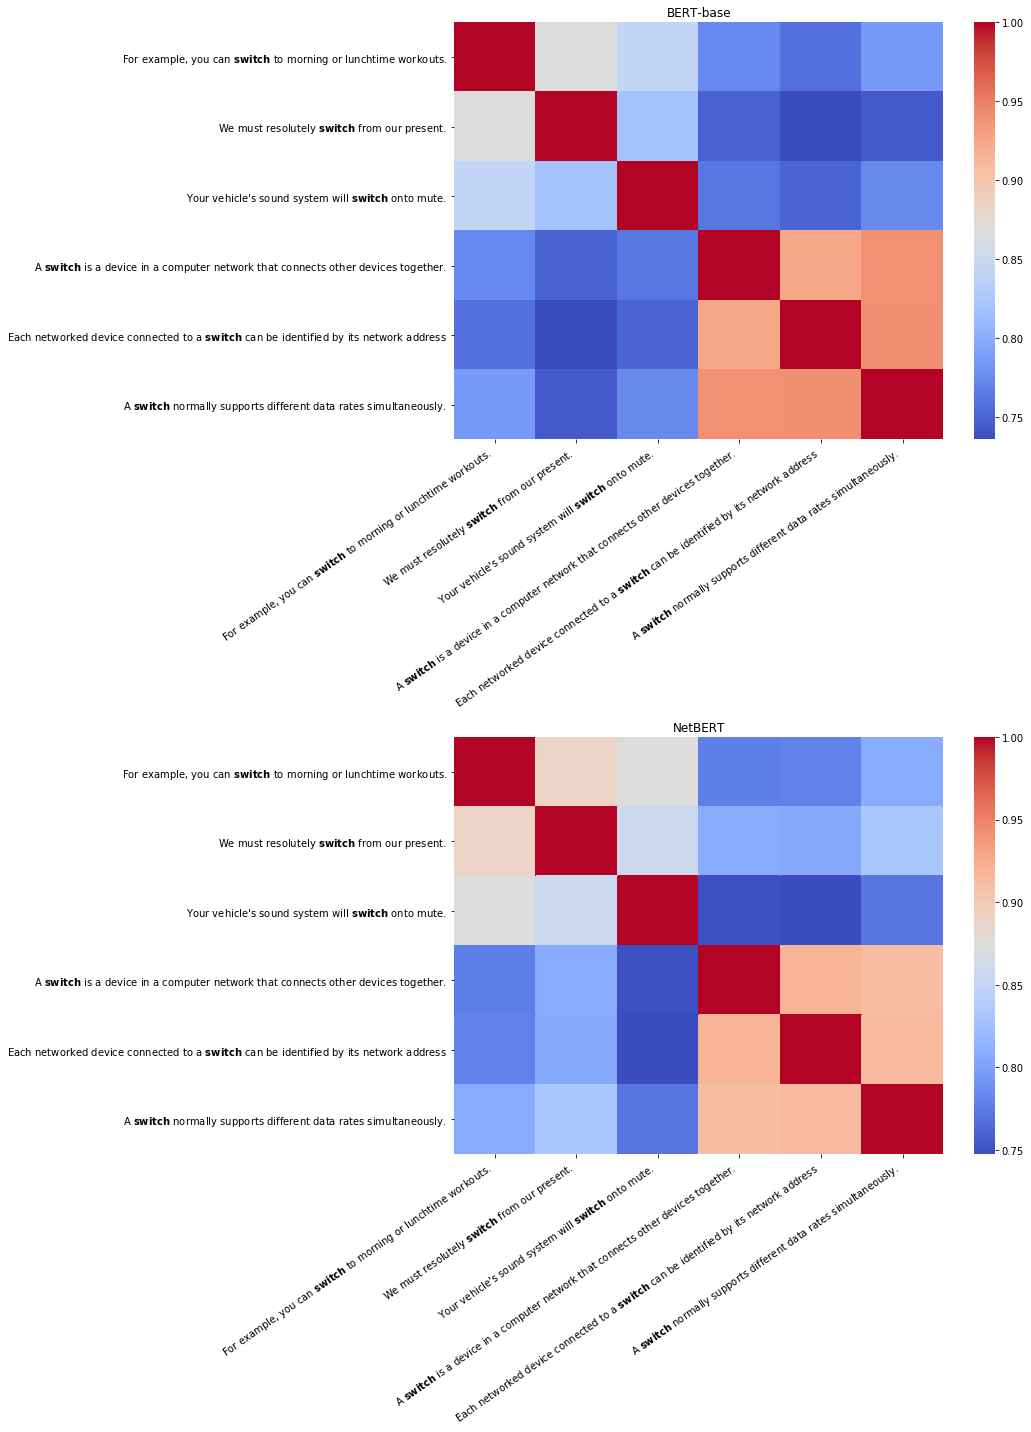

In [94]:
def compute_cosine_matrix(embeddings):
    """
    """
    matrix = np.zeros((len(sentences), len(sentences)))
    for i, sent in enumerate(sentences):
        for j, sent in enumerate(sentences):
            matrix[i,j] = 1 - cosine(embeddings[i], embeddings[j])
    return matrix


# Get embeddings.
bert_embeddings = bert_df.loc[:, ~bert_df.columns.isin(['Token','Sentence'])].values
netbert_embeddings = netbert_df.loc[:, ~netbert_df.columns.isin(['Token','Sentence'])].values

# Compute matrix.
bert_matrix = compute_cosine_matrix(bert_embeddings)
netbert_matrix = compute_cosine_matrix(netbert_embeddings)

# Create dataframes.
bert_cm = pd.DataFrame(bert_matrix, index=labels, columns=labels)
netbert_cm = pd.DataFrame(netbert_matrix, index=labels, columns=labels)

# Create heatmaps.
fig = plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(2, 1, 1)
sn.heatmap(bert_cm, annot=False, cmap="coolwarm")
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10, horizontalalignment='right', rotation=35) 
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
ax1.set_title("BERT-base")

ax2 = fig.add_subplot(2, 1, 2)
sn.heatmap(netbert_cm, annot=False, cmap="coolwarm")
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=10, horizontalalignment='right', rotation=35) 
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10)
ax2.set_title("NetBERT")

plt.tight_layout()
plt.show()
#plt.savefig(outdir+"confusion_matrix.png")

### Observations
